<a href="https://colab.research.google.com/github/bbchen33/Deep-learning/blob/master/Heart_disease_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Tensorflow to analyze UCI heart disease data.

In [0]:
## https://www.tensorflow.org/tutorials/structured_data/feature_columns

import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd


In [0]:
!unzip heart-disease-uci.zip

Archive:  heart-disease-uci.zip
  inflating: heart.csv               


In [0]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Taking a look at the data.

In [0]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [0]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

All the data features are numerical so there's no need to encode the categorical feature.

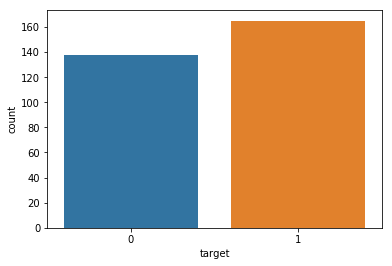

In [0]:
sns.countplot(data.target)

Text(0.5, 0, 'heart disease')

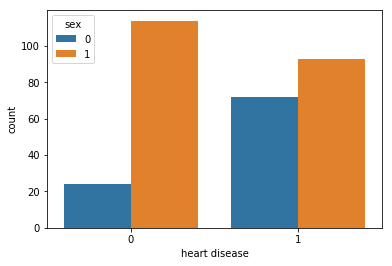

In [0]:
sns.countplot(data.target,hue = data.sex)
plt.xlabel('heart disease')

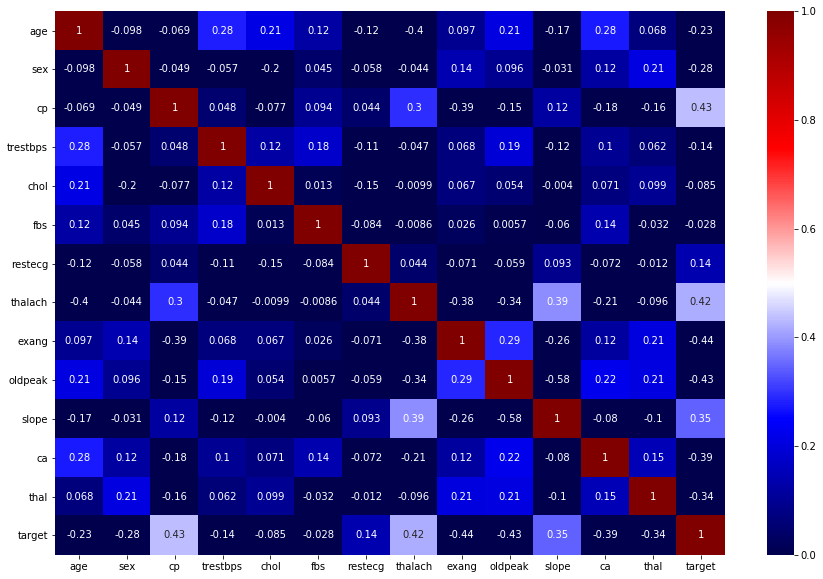

In [0]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(method= 'pearson'), annot = True, vmin = 0, vmax = 1, cmap = 'seismic')

No strong correlation between the features (red being strong and blue being weak)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X = data.drop(['target'], axis =1)
y = data.target
X_std = StandardScaler().fit_transform(X)

print('Before:\n',X.mean(axis = 0),'\nAfter\n',X_std.mean(axis = 0))


Before:
 age          54.366337
sex           0.683168
cp            0.966997
trestbps    131.623762
chol        246.264026
fbs           0.148515
restecg       0.528053
thalach     149.646865
exang         0.326733
oldpeak       1.039604
slope         1.399340
ca            0.729373
thal          2.313531
dtype: float64 
After
 [ 4.69005106e-17 -1.40701532e-16  2.34502553e-17 -7.03507659e-16
 -1.11388713e-16 -2.34502553e-17  1.46564096e-16 -6.80057404e-16
 -4.69005106e-17  2.34502553e-17 -1.40701532e-16 -2.34502553e-17
 -1.64151787e-16]


In [0]:
pca= PCA(n_components = 2)
PCs = pca.fit_transform(X_std)
principalDF = pd.DataFrame(data = PCs, columns = ['PC1','PC2'])

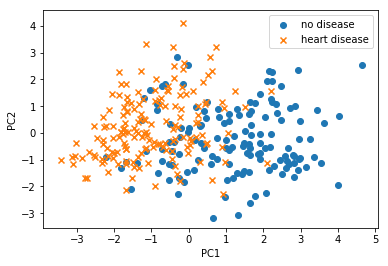

In [0]:
plt.scatter(principalDF.PC1[y==0], principalDF.PC2[y==0], marker = 'o', label= 'no disease')
plt.scatter(principalDF.PC1[y==1], principalDF.PC2[y==1], marker = 'x', label= 'heart disease')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

In [0]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [0]:
shuffle_data = data.sample(frac = 1)
print(shuffle_data.shape)
train, val, test = shuffle_data[:200], shuffle_data[200:251], shuffle_data[202:303]

(303, 14)


In [0]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [0]:
feature_columns = []
for item in ['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']:
  feature_columns.append(tf.feature_column.numeric_column(item))
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, boundaries = list(range(20,70,5)))
feature_columns.append(age_buckets)
print(len(feature_columns))

13


In [0]:
def df_to_dataset(df, batch_size, shuffle = True):
  df = df.copy()
  labels = df.target
  dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle == True:
    dataset = dataset.shuffle(buffer_size = len(df))
  final_ds = dataset.batch(batch_size)
  return final_ds

In [0]:
train_ds = df_to_dataset(train, 30)
val_ds = df_to_dataset(val, 30, shuffle = False)
test_ds = df_to_dataset(train, 30, shuffle = False)


In [0]:
from tensorflow.keras import layers

feature_layer = layers.DenseFeatures(feature_columns)
print(feature_layer(next(iter(train_ds))[0]))

Tensor("dense_features/concat:0", shape=(?, 23), dtype=float32)


Trying the first model with just a few layers. 

In [0]:
model = tf.keras.models.Sequential([
  feature_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=10, use_multiprocessing=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
7/7 [==============================] - 1s 149ms/step - loss: 3.2859 - acc: 0.5550 - val_loss: 1.4772 - val_acc: 0.5490
Epoch 2/10
7/7 [==============================] - 0s 9ms/step - loss: 1.8910 - acc: 0.5950 - val_loss: 2.3897 - val_acc: 0.5098
Epoch 3/10
7/7 [==============================] - 0s 8ms/step - loss: 1.3625 - acc: 0.6350 - val_loss: 0.9982 - val_acc: 0.6275
Epoch 4/10
7/7 [==============================] - 0s 8ms/step - loss: 1.0799 - acc: 0.5750 - val_loss: 1.2746 - val_acc: 0.5882
Epoch 5/10
7/7 [==============================] - 0s 7ms/step - loss: 1.0231 - acc: 0.6200 - val_loss: 0.8006 - val_acc: 0.7059
Epoch 6/10
7/7 [==============================] - 0s 7ms/step - loss: 0.6562 - acc: 0.7050 - val_loss: 0.7853 - val_acc: 0.6863
Epoch 7/10
7/7 [==============================] - 0s 8ms/step - loss: 0.7207 - acc: 0.6600 - val_loss: 0.7642 - val_acc: 0.6471
Epoch 8/

In [0]:
model.evaluate(test_ds)

7/7 [==============================] - 0s 18ms/step - loss: 0.4869 - acc: 0.7600


[0.48693552187510897, 0.76]

The accuracy is not super high but since only 10 epochs were run. The model could be improved by having more epochs or increasing the number of layers in the network.

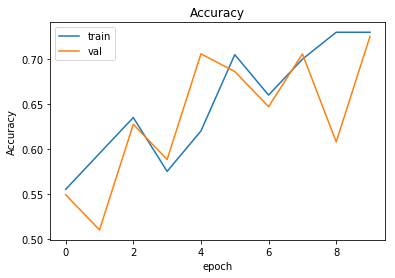

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

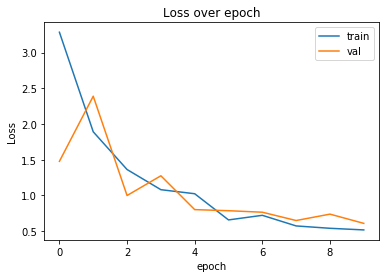

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

In [0]:
history2 = model.fit(train_ds, validation_data=val_ds, epochs=50, use_multiprocessing=True)

Epoch 1/50
7/7 [==============================] - 0s 52ms/step - loss: 0.4997 - acc: 0.7700 - val_loss: 0.6234 - val_acc: 0.7255
Epoch 2/50
7/7 [==============================] - 0s 7ms/step - loss: 0.5384 - acc: 0.7450 - val_loss: 0.5746 - val_acc: 0.7843
Epoch 3/50
7/7 [==============================] - 0s 7ms/step - loss: 0.5128 - acc: 0.7350 - val_loss: 0.6337 - val_acc: 0.6667
Epoch 4/50
7/7 [==============================] - 0s 9ms/step - loss: 0.4969 - acc: 0.7450 - val_loss: 0.5706 - val_acc: 0.7647
Epoch 5/50
7/7 [==============================] - 0s 8ms/step - loss: 0.4566 - acc: 0.7650 - val_loss: 0.5714 - val_acc: 0.7451
Epoch 6/50
7/7 [==============================] - 0s 7ms/step - loss: 0.5052 - acc: 0.7450 - val_loss: 0.5660 - val_acc: 0.8039
Epoch 7/50
7/7 [==============================] - 0s 7ms/step - loss: 0.4953 - acc: 0.7500 - val_loss: 0.6078 - val_acc: 0.6863
Epoch 8/50
7/7 [==============================] - 0s 8ms/step - loss: 0.6176 - acc: 0.6850 - val_loss: 

In [0]:
model.evaluate(test_ds)

7/7 [==============================] - 0s 21ms/step - loss: 0.3231 - acc: 0.8550


[0.32306741390909466, 0.855]

Got 85% accuracy. Not bad.

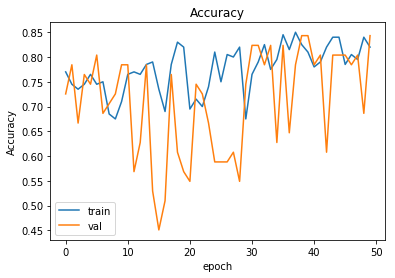

In [0]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

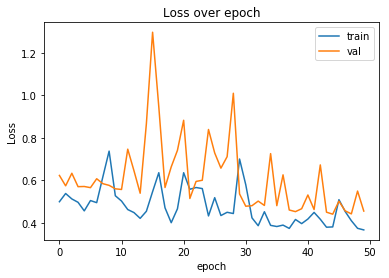

In [0]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss over epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

All of the features in the dataframe have been transformed into numerical values but in case that a feature is categorical value. Below is the method to map the feature back to its category and to numbers.

In [0]:
class_mapping = {1: 'fixed', 2: 'normal', 3: 'reversible'}


In [0]:
data['thal_group'] = data.thal.map(class_mapping)

In [0]:
thal = tf.feature_column.categorical_column_with_vocabulary_list('thal', ['fixed','normla','reversible'])
